# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


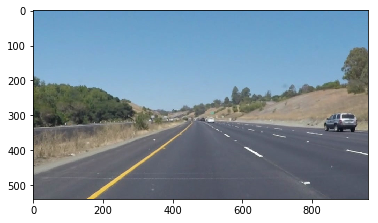

In [2]:
#reading in an image
# img_name = 'solidWhiteRight.jpg'
# img_name = 'whiteCarLaneSwitch.jpg'
img_name = 'solidYellowCurve.jpg'
# img_name = 'solidWhiteCurve.jpg'
# img_name = 'solidYellowCurve2.jpg'
# img_name = 'solidYellowLeft.jpg'

image = mpimg.imread('test_images/' + img_name)

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [82]:
import math
from scipy import stats

# global variables
frame = 0
previous_left_lines = []
previous_right_lines = []
img_width = 100
img_height = 100
mask_verts = []

# Renders a line
# 
# param     img         The image to render to
# param     line        The line to render
# param     color       The color of the line
# param     thickness   The thickness of the line
#
def renderLine(img, line, color = [255,0,0], thickness = 1):
    for x1, y1, x2, y2 in line:
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

# Renders a collection of lines
# 
# param     img         The image to render to
# param     lines       The collection of lines to render
# param     color       The color of the lines
# param     thickness   The thickness of the lines
#
def renderLines(img, lines, color = [255,0,0], thickness = 1):
    for line in lines:
        renderLine(img, line, color, thickness)

# Calculates a new line given 2 points and upper/bottom bounds
#
# param     line        line defined by slope and y-intercept
# param     top_y       y coordinate of the top of the new line
# param     bottom_y    y coordinate of of the bottom of the new line
# returns               the 2 points of the discovered line
#
def extrapolateLine(line, top_y, bottom_y):
    # first get the slope
    bottom_x = 0
    top_x = 0
    for slope, intercept in line:
        bottom_x = (bottom_y - intercept)/slope
        top_x = (top_y - intercept)/slope
    
    return np.array([[bottom_x, bottom_y, top_x, top_y]], dtype = line.dtype)

# Wrapper for the grayscale function
#
# param    img      The img to convert
# param    bPlot    True, to plot the image
# returns           The grayscaled image
#
def grayscaleW(img, bPlot=False):
    gray = grayscale(img)
    if (bPlot):
        plt.imshow(gray, cmap='gray')
    return gray

# Mask out all colors but yellow and white
#
# param    img             The image to mask
# param    white_range     The range of white color to mask
# param    yellow_range    The range of yellow color to mask
# param    bPlot           True, to plot the image
# returns                  The color masked image
#
def colorMask(img, white_range, yellow_range, bPlot=False):
    gray = grayscaleW(img)
    low_res = (gray / 2).astype('uint8')
    hsv_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    white_mask = cv2.inRange(hsv_image, white_range[0], white_range[1])
    yellow_mask = cv2.inRange(hsv_image, yellow_range[0], yellow_range[1])
    yellow_white_mask = cv2.bitwise_and(white_mask, yellow_mask)
    masked_image = cv2.bitwise_or(low_res, yellow_white_mask)
    if (bPlot):
        plt.imshow(masked_image)
    return masked_image

# Wrapper for the gaussian_blur function
#
# param    img            The img to convert
# param    kernel_size    The size of kernel to apply
# param    bPlot          True, to plot the image
# returns                 The blurred image
#
def gaussianblurW(img, kernel_size, bPlot=False):
    blurred = gaussian_blur(img, kernel_size)
    if (bPlot):
        plt.imshow(blurred, cmap='gray')
    return blurred

# Wrapper for the canny function
#
# param    img               The img to convert
# param    low_threshold     Values below this will be discarded
# param    high_threshold    Values above this will be included
# param    bPlot             True, to plot the image
# returns                    The gradient image
#
def cannyW(img, low_threshold, high_threshold, bPlot=False):
    gradient = canny(img, low_threshold, high_threshold)
    if (bPlot):
        plt.imshow(gradient, cmap='gray')
    return gradient

# Wrapper for the region_of_interest function
#
# param    img         The img to convert
# param    verts    The region to mask
# param    bPlot       True, to plot the image
# returns              The masked image
#
def maskRegionW(img, verts, bPlot=False):
    masked_region = region_of_interest(img, verts)
    if (bPlot):
        plt.imshow(masked_region, cmap='gray')
    return masked_region

# Wrapper for the hough_lines function
#
# param    img               The img to convert
# param    rho               The granularity of the rho parameter
# param    theta             The granularity of the theta parameter
# param    threshold         The minimum required votes
# param    minimum_length    The minimum require line length
# param    maximum_gap       The maximum allowed gap
# param    bPlot             True, to plot the image
# returns                    The image with detected lines
#
def houghTransformW(img, rho, theta, threshold, minimum_length, maximum_gap, bPlot=False):
    lines = hough_lines(img, rho, theta, threshold, minimum_length, maximum_gap)
    if (bPlot):
        plt.imshow(lines)
    return lines

# Wrapper for the hough_lines function
#
# param    imgA              The first image to combine
# param    imgB              The second image to combine
# param    α                 Weight of the first image
# param    β                 Weight of the second image
# param    λ                 Scalar added to each image
# param    bPlot             True, to plot the image
# returns                    The combined image
#
def combineImagesW(imgA, imgB, α=0.8, β=1., λ=0., bPlot=False):
    combined_img = weighted_img(imgA, imgB, α, β, λ)
    if bPlot:
        plt.imshow(combined_img)
    return combined_img

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).

    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """

    global frame
    global previous_left_lines
    global previous_right_lines
    max_history = 5  # number of previous frames to average
    frame += 1       # increment the frame counter

    # find line params (slope & y-intercept
    # Split into left and right groups based on slope
    slope_threshold = 0.4    # do not include lines with slopes between [-slope_threshold, slope_threshold[
    left_lines = []
    left_weights = []
    right_lines = []
    right_weights = []
    test_left_lines = []
    test_right_lines = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            # Calculate slope, y-intercept and the length of the vector
            diff = (x2 - x1, y2 - y1)
            # discard inf sloped lines
            if diff[0] == 0:
                continue
            slope = diff[1] / diff[0]
            intercept = y1 - slope * x1
            weight = np.linalg.norm(diff)
            # if the slop is less than -slope_threshold
            # add it to the left lines
            if slope < -slope_threshold:
                left_lines.append([[slope, intercept]])
                left_weights.append(weight)
                test_left_lines.append(line)
            # if the slop is greater than slope_threshold
            # add it to the right lines
            elif slope > slope_threshold:
                right_lines.append([[slope, intercept]])
                right_weights.append(weight)
                test_right_lines.append(line)
       
    # Discard outliers
#     mean = np.mean(left_lines, axis=0)
#     standard_deviation = np.std(left_lines, axis=0)
#     deviations = np.absolute(left_lines - mean)
#     deviation_threshold = 1.
#     accepted_left_lines = deviations[:, 0, 0] < deviation_threshold
#     left_lines = left_lines[deviations[:,0] < deviation_threshold]

#     print("length", len(left_lines))
#     print("left", left_lines)
    # only calculate the new average if there are any left lines
    if len(left_lines) > 0:
        # average the new line params
        new_avg_left = np.average(left_lines, axis=0)
        # average the last max_history frames if available
        previous_left_lines.insert(0, new_avg_left)

    # only calculate the new average if there are any right lines
    if len(right_lines) > 0:
        # average the new line params
        new_avg_right = np.average(right_lines, axis=0)
        # average the last max_history frames if available
        previous_right_lines.insert(0, new_avg_right)

    # Now average the new line with the previous lines (if available)
    # Decrement the weight of the line based on how far in the past it is
    previous_left_lines = previous_left_lines[:min(frame, max_history)]
    avg_left = np.average(previous_left_lines, axis=0, weights = np.linspace(1., 0.5, min(frame, max_history)))

    # Now average the new line with the previous lines (if available)
    # Decrement the weight of the line based on how far in the past it is (present = 1, oldest = 0.5)
    previous_right_lines = previous_right_lines[:min(frame, max_history)]
    avg_right = np.average(previous_right_lines, axis=0, weights = np.linspace(1., 0.5, min(frame, max_history)))

    # Extrapolate the lines the render
    left_line = extrapolateLine(avg_left, mask_verts[0,1,1], mask_verts[0,0,1])
    right_line = extrapolateLine(avg_right, mask_verts[0,2,1], mask_verts[0,3,1])

    # Convert back to integer array
    left_line = left_line.astype(lines.dtype)
    right_line = right_line.astype(lines.dtype)

    # Render the extrapolated lines
    renderLine(img, left_line, [0, 255, 255], 10)
    renderLine(img, right_line, [255, 255, 0], 10)
#     renderLines(img, test_left_lines, [255, 0, 0], 2)
#     renderLines(img, test_right_lines, [255, 0, 255], 2)
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['.DS_Store',
 'laneLines_thirdPass.jpg',
 'line-segments-example.jpg',
 'result_test.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

True

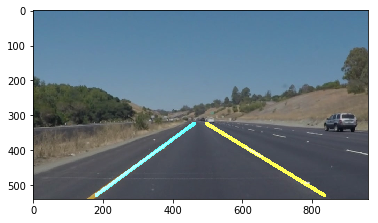

In [83]:
# === Define the parameters for the pipeline =================
global img_width
global img_height
img_width = image.shape[1]
img_height = image.shape[0]

# === Color Masking ==========================================

white_range = np.array([[0, 0, 0], [255, 255, 255]])
yellow_range = np.array([[20, 100, 100], [35, 255, 255]])

# === Gaussian Blur ==========================================

kernel_size = 5

# === Canny Edge =============================================

low_threshold = 50
high_threshold = 150

# === Region Masking =========================================

global vanishing_point
vanishing_point = [img_width * 0.5, img_height * 0.6]
vanishing_point_width = .05
vert_bottom_left = [img_width * 0.01, img_height * 0.98]
vert_bottom_right = [img_width * 0.99, img_height * 0.98]
vert_top_left = [vanishing_point[0] - img_width * vanishing_point_width, vanishing_point[1]]
vert_top_right = [vanishing_point[0] + img_width * vanishing_point_width, vanishing_point[1]]
global mask_verts
mask_verts = np.array([[vert_bottom_left, vert_top_left, vert_top_right, vert_bottom_right]], dtype=np.int32)

# === Hough Transform ========================================

rho = 1
theta = np.pi / 180
hough_threshold = 10
minimum_line_length = 20
maximum_line_gap = 10

# === Lane Detection Pipeline ================================

# Create yellow & white color masks
color_masked = colorMask(image, white_range, yellow_range, bPlot=False)

# Apply a Gaussian Blur to reduce noise in Canny Edge Detection
blurred = gaussianblurW(color_masked, kernel_size)

# Apply Canny Edge Edge on the blurred image
gradient = cannyW(blurred, low_threshold, high_threshold, bPlot = False)

# Mask out the region of interest
masked_region = maskRegionW(gradient, mask_verts, bPlot = False)

# Run the Hough Transform on the masked image to detect lines in the image
lines = houghTransformW(masked_region, rho, theta, hough_threshold, minimum_line_length, maximum_line_gap, bPlot = False)

# Render the lines on top of the original image
final_img = combineImagesW(lines, image, β=1.0, bPlot=True)

# Render the masked region boundary
#     cv2.polylines(final_img, vertices, 1, (0,255,0), thickness=3)

# save the resulting image in the test_images directory
img_out = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
# cv2.imwrite('test_images/result_' + str(i+1) + '.jpg' ,img_out)
cv2.imwrite('test_images/result_test.jpg' ,img_out)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [84]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [92]:
def process_image(image):
    # === Define the parameters for the pipeline =================

    global img_width
    global img_height
    img_width = image.shape[1]
    img_height = image.shape[0]

    # === Color Masking ==========================================

    white_range = np.array([[150, 150, 150], [255, 255, 255]])
    yellow_range = np.array([[20, 100, 100], [35, 255, 255]])

    # === Gaussian Blur ==========================================

    kernel_size = 5

    # === Canny Edge =============================================

    low_threshold = 50
    high_threshold = 150

    # === Region Masking =========================================

    global vanishing_point
    vanishing_point = [img_width * 0.5, img_height * 0.6]
    vanishing_point_width = .05
    vert_bottom_left = [img_width * 0.01, img_height * 0.98]
    vert_bottom_right = [img_width * 0.99, img_height * 0.98]
    vert_top_left = [vanishing_point[0] - img_width * vanishing_point_width, vanishing_point[1]]
    vert_top_right = [vanishing_point[0] + img_width * vanishing_point_width, vanishing_point[1]]
    global mask_verts
    mask_verts = np.array([[vert_bottom_left, vert_top_left, vert_top_right, vert_bottom_right]], dtype=np.int32)

    # === Hough Transform ========================================

    rho = 1
    theta = np.pi / 180
    hough_threshold = 10
    minimum_line_length = 20
    maximum_line_gap = 10

    # === Lane Detection Pipeline ================================

    # Create yellow & white color masks
    color_masked = colorMask(image, white_range, yellow_range, bPlot=False)

    # Apply a Gaussian Blur to reduce noise in Canny Edge Detection
    blurred = gaussianblurW(color_masked, kernel_size)

    # Apply Canny Edge Edge on the blurred image
    gradient = cannyW(blurred, low_threshold, high_threshold)

    # Mask out the region of interest
    masked_region = maskRegionW(gradient, mask_verts)

    # Run the Hough Transform on the masked image to detect lines in the image
    lines = houghTransformW(masked_region, rho, theta, hough_threshold, minimum_line_length, maximum_line_gap)

    # Render the lines on top of the original image
    result = combineImagesW(lines, image, β=0.8)

    # Render the masked region boundary
    # cv2.polylines(result, mask_verts, 1, (0,255,0), thickness=3)

    # save the resulting image in the test_images directory
    #img_out = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #cv2.imwrite('testChallengeVideo/result_' + str(frame) + '.jpg', img_out)

    return result

Let's try the one with the solid white lane on the right first ...

In [93]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:03<00:00, 69.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.74 s, sys: 1.38 s, total: 5.12 s
Wall time: 3.52 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [94]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [95]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:12<00:00, 54.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 13.1 s, sys: 3.77 s, total: 16.8 s
Wall time: 13 s


In [96]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [97]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:07<00:00, 34.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 8.05 s, sys: 2.25 s, total: 10.3 s
Wall time: 8.08 s


In [98]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))